<a href="https://colab.research.google.com/github/estebanegm/PINN_example/blob/main/PINN_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Época 0, Pérdida: 246.77137756347656
Época 100, Pérdida: 61.48810577392578
Época 200, Pérdida: 30.002342224121094
Época 300, Pérdida: 25.425031661987305
Época 400, Pérdida: 21.180349349975586
Época 500, Pérdida: 17.137344360351562
Época 600, Pérdida: 10.96965217590332
Época 700, Pérdida: 2.130542039871216
Tiempo de entrenamiento: 55.50 segundos


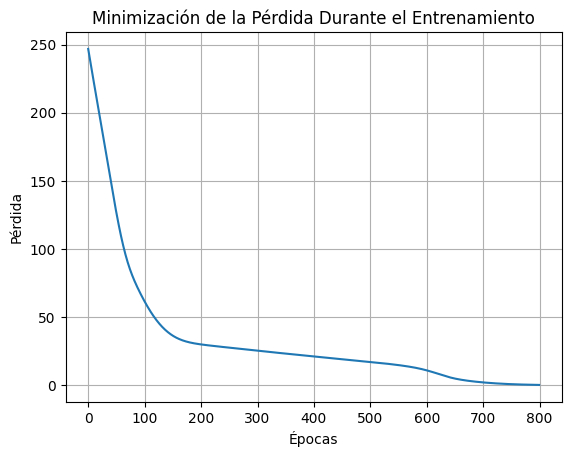

<ipython-input-2-3e66141d2517>:149: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_test, T_real, 'r--', label='Solución Exacta', color='red')


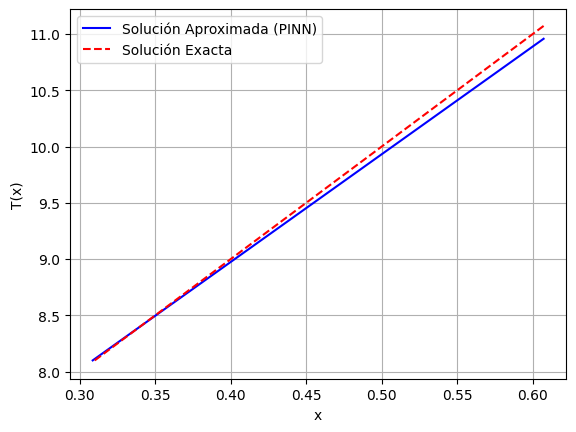

Error Absoluto Medio (MAE): 0.06388681655417727
Error Cuadrático Medio (MSE): 0.006612803774189983
Precisión: 99.33%


In [2]:
# 1: Importar bibliotecas necesarias
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 2: Definición de la red neuronal (PINN)
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(40, activation='tanh')
        self.hidden_layer_2 = tf.keras.layers.Dense(40, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, x):
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        return self.output_layer(x)

# Crear la instancia del modelo
modelo = PINN()

# 3: Definición de la función de pérdida
def loss_function(model, x_interior, x_frontera_0, x_frontera_f, T_frontera_0, T_frontera_f):
    # Loss en el dominio interior (ec. dif.)
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x_interior)
        with tf.GradientTape() as tape1:
            tape1.watch(x_interior)
            T_interior_pred = model(x_interior)
        dT_dx = tape1.gradient(T_interior_pred, x_interior)  # Primera derivada de T
    d2T_dx2 = tape2.gradient(dT_dx, x_interior)  # Segunda derivada de T

    # El residuo es la diferencia con la ecuación d²T/dx² = 0
    interior_loss = tf.reduce_mean(tf.square(d2T_dx2))

    # Loss en las condiciones de frontera
    T_pred_0 = model(x_frontera_0)  # Predicción en x = 0
    T_pred_f = model(x_frontera_f)  # Predicción en x = 1
    boundary_loss_0 = tf.reduce_mean(tf.square(T_pred_0 - T_frontera_0))  # Error en T(0)
    boundary_loss_f = tf.reduce_mean(tf.square(T_pred_f - T_frontera_f))  # Error en T(L)

    # Total loss (dominio interior + condiciones de frontera)
    return interior_loss + boundary_loss_0 + boundary_loss_f

# 4: Generar los datos (puntos en el dominio y las fronteras) de manera aleatoria
def generate_training_data(T0, Tf, L, n_puntos):
    # Generación de puntos aleatorios en el dominio [0, L] para x
    x_interior = np.random.uniform(0, L, n_puntos).reshape(-1, 1)

    # Se usa la solución exacta para obtener los valores de T
    T_interior = T0 + (Tf - T0) * (x_interior / L)  # Solución exacta T(x)

    # Condiciones de frontera
    x_frontera_0 = np.array([[0.0]])  # x = 0
    x_frontera_f = np.array([[L]])    # x = L
    T_frontera_0 = np.array([[T0]])   # T(0) = T0
    T_frontera_f = np.array([[Tf]])   # T(L) = Tf

    # Convertir los puntos y valores a tensores de TensorFlow
    x_interior_tf = tf.convert_to_tensor(x_interior, dtype=tf.float32)
    x_frontera_0_tf = tf.convert_to_tensor(x_frontera_0, dtype=tf.float32)
    x_frontera_f_tf = tf.convert_to_tensor(x_frontera_f, dtype=tf.float32)
    T_frontera_0_tf = tf.convert_to_tensor(T_frontera_0, dtype=tf.float32)
    T_frontera_f_tf = tf.convert_to_tensor(T_frontera_f, dtype=tf.float32)

    return x_interior_tf, x_frontera_0_tf, x_frontera_f_tf, T_frontera_0_tf, T_frontera_f_tf, x_interior, T_interior

# Definición de condiciones de frontera y datos generados
T0 = 5   # Temperatura en x = 0
Tf = 15  # Temperatura en x = L
L = 1    # Longitud del dominio
n_puntos = 10  # Número de puntos aleatorios en el dominio interior

# Llamar a la función para generar los datos de entrenamiento
x_interior_tf, x_frontera_0_tf, x_frontera_f_tf, T_frontera_0_tf, T_frontera_f_tf, x_interior, T_interior = generate_training_data(T0, Tf, L, n_puntos)

# Paso 5: División aleatoria de datos en entrenamiento y prueba (80% - 20%)
total_length = x_interior.shape[0]
train_length = int(0.8 * total_length)  # 80% para entrenamiento
test_length = total_length - train_length  # 20% para prueba

# Revolver los índices de los datos de manera aleatoria
indices = np.random.permutation(total_length)
train_indices = indices[:train_length]
test_indices = indices[train_length:]

# División de los datos aleatoriamente
X_train = x_interior[train_indices]
X_test = x_interior[test_indices]
y_train = T_interior[train_indices]
y_test = T_interior[test_indices]

# 6: Entrenamiento de la red neuronal
def entrenar_modelo(modelo, opt, x_interior, x_frontera_0, x_frontera_f, T_frontera_0, T_frontera_f, epochs=780):
    # Lista para almacenar la pérdida en cada época
    historial_perdida = []

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            # Calcular la función de pérdida
            perdida = loss_function(modelo, x_interior, x_frontera_0, x_frontera_f, T_frontera_0, T_frontera_f)

        # Almacenar la pérdida actual
        historial_perdida.append(perdida.numpy())

        # Calcular gradientes y aplicar optimización
        gradients = tape.gradient(perdida, modelo.trainable_variables)
        opt.apply_gradients(zip(gradients, modelo.trainable_variables))

        # Imprimir la pérdida cada 100 épocas
        if epoch % 100 == 0:
            print(f"Época {epoch}, Pérdida: {perdida.numpy()}")

    return historial_perdida

# Entrenar el modelo y almacenar la pérdida
import time
start_time = time.time()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
historial_perdida = entrenar_modelo(modelo, opt, x_interior_tf, x_frontera_0_tf, x_frontera_f_tf, T_frontera_0_tf, T_frontera_f_tf, epochs=800)
end_time = time.time()
training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")

# 7: Graficar la función de pérdida en función de las épocas
def graficar_perdida(historial_perdida):
    plt.plot(historial_perdida)
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Minimización de la Pérdida Durante el Entrenamiento')
    plt.grid(True)  # Agregar cuadrícula
    plt.show()

# Graficar el historial de la pérdida
graficar_perdida(historial_perdida)

# 8: Visualizar la solución aproximada y la solución exacta
def graficar_solucion(modelo, T0, Tf, x_test, y_test):
    # Predicción de la red neuronal
    x_test_tf = tf.convert_to_tensor(x_test, dtype=tf.float32)
    T_predicho = modelo(x_test_tf).numpy()

    # Solución exacta usando T(x) = T0 + (Tf - T0) * x
    T_real = T0 + (Tf - T0) * x_test

    # Graficamos la solución aproximada y la solución real
    plt.plot(x_test, T_predicho, label='Solución Aproximada (PINN)', color='blue')
    plt.plot(x_test, T_real, 'r--', label='Solución Exacta', color='red')
    plt.xlabel('x')
    plt.ylabel('T(x)')
    plt.legend()
    plt.grid(True)  # Agregar cuadrícula
    plt.show()

    # Calcular y mostrar el Error Absoluto Medio (MAE)
    mae = np.mean(np.abs(T_predicho.flatten() - y_test.flatten()))  # MAE
    print(f"Error Absoluto Medio (MAE): {mae}")

    # Calcular y mostrar la precisión (MSE)
    mse = np.mean((T_predicho.flatten() - y_test.flatten())**2)
    print(f"Error Cuadrático Medio (MSE): {mse}")

    # Calcular y mostrar la precisión (en porcentaje)
    mae = np.mean(np.abs(T_predicho.flatten() - y_test.flatten()))  # Error absoluto medio (MAE)
    valor_medio_real = np.mean(y_test)  # Valor promedio de los datos de prueba reales
    precision = 100 * (1 - mae / valor_medio_real)  # Precisión en porcentaje

    print(f"Precisión: {precision:.2f}%")

# Llamada a la función para graficar la solución
graficar_solucion(modelo, T0, Tf, X_test, y_test)

In [ ]:
# 1: Importar bibliotecas necesarias
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 2: Definición de la red neuronal (PINN)
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(40, activation='tanh')
        self.hidden_layer_2 = tf.keras.layers.Dense(40, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, x):
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        return self.output_layer(x)

# Crear la instancia del modelo
modelo = PINN()

In [ ]:
# 3: Definición de la función de pérdida
def loss_function(model, x_interior, x_frontera_0, x_frontera_f, T_frontera_0, T_frontera_f):
    # Loss en el dominio interior (ec. dif.)
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x_interior)
        with tf.GradientTape() as tape1:
            tape1.watch(x_interior)
            T_interior_pred = model(x_interior)
        dT_dx = tape1.gradient(T_interior_pred, x_interior)  # Primera derivada de T
    d2T_dx2 = tape2.gradient(dT_dx, x_interior)  # Segunda derivada de T

    # El residuo es la diferencia con la ecuación d²T/dx² = 0
    interior_loss = tf.reduce_mean(tf.square(d2T_dx2))

    # Loss en las condiciones de frontera
    T_pred_0 = model(x_frontera_0)  # Predicción en x = 0
    T_pred_f = model(x_frontera_f)  # Predicción en x = 1
    boundary_loss_0 = tf.reduce_mean(tf.square(T_pred_0 - T_frontera_0))  # Error en T(0)
    boundary_loss_f = tf.reduce_mean(tf.square(T_pred_f - T_frontera_f))  # Error en T(L)

    # Total loss (dominio interior + condiciones de frontera)
    return interior_loss + boundary_loss_0 + boundary_loss_f

In [ ]:
# 4: Generar los datos (puntos en el dominio y las fronteras) de manera aleatoria
def generate_training_data(T0, Tf, L, n_puntos):
    # Generación de puntos aleatorios en el dominio [0, L] para x
    x_interior = np.random.uniform(0, L, n_puntos).reshape(-1, 1)

    # Se usa la solución exacta para obtener los valores de T
    T_interior = T0 + (Tf - T0) * (x_interior / L)  # Solución exacta T(x)

    # Condiciones de frontera
    x_frontera_0 = np.array([[0.0]])  # x = 0
    x_frontera_f = np.array([[L]])    # x = L
    T_frontera_0 = np.array([[T0]])   # T(0) = T0
    T_frontera_f = np.array([[Tf]])   # T(L) = Tf

    # Convertir los puntos y valores a tensores de TensorFlow
    x_interior_tf = tf.convert_to_tensor(x_interior, dtype=tf.float32)
    x_frontera_0_tf = tf.convert_to_tensor(x_frontera_0, dtype=tf.float32)
    x_frontera_f_tf = tf.convert_to_tensor(x_frontera_f, dtype=tf.float32)
    T_frontera_0_tf = tf.convert_to_tensor(T_frontera_0, dtype=tf.float32)
    T_frontera_f_tf = tf.convert_to_tensor(T_frontera_f, dtype=tf.float32)

    return x_interior_tf, x_frontera_0_tf, x_frontera_f_tf, T_frontera_0_tf, T_frontera_f_tf, x_interior, T_interior

# Definición de condiciones de frontera y datos generados
T0 = 5   # Temperatura en x = 0
Tf = 15  # Temperatura en x = L
L = 1    # Longitud del dominio
n_puntos = 10  # Número de puntos aleatorios en el dominio interior

# Llamar a la función para generar los datos de entrenamiento
x_interior_tf, x_frontera_0_tf, x_frontera_f_tf, T_frontera_0_tf, T_frontera_f_tf, x_interior, T_interior = generate_training_data(T0, Tf, L, n_puntos)

In [ ]:
# Paso 5: División aleatoria de datos en entrenamiento y prueba (80% - 20%)
total_length = x_interior.shape[0]
train_length = int(0.8 * total_length)  # 80% para entrenamiento
test_length = total_length - train_length  # 20% para prueba

# Revolver los índices de los datos de manera aleatoria
indices = np.random.permutation(total_length)
train_indices = indices[:train_length]
test_indices = indices[train_length:]

# División de los datos aleatoriamente
X_train = x_interior[train_indices]
X_test = x_interior[test_indices]
y_train = T_interior[train_indices]
y_test = T_interior[test_indices]

In [ ]:
# 6: Entrenamiento de la red neuronal
def entrenar_modelo(modelo, opt, x_interior, x_frontera_0, x_frontera_f, T_frontera_0, T_frontera_f, epochs=780):
    # Lista para almacenar la pérdida en cada época
    historial_perdida = []

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            # Calcular la función de pérdida
            perdida = loss_function(modelo, x_interior, x_frontera_0, x_frontera_f, T_frontera_0, T_frontera_f)

        # Almacenar la pérdida actual
        historial_perdida.append(perdida.numpy())

        # Calcular gradientes y aplicar optimización
        gradients = tape.gradient(perdida, modelo.trainable_variables)
        opt.apply_gradients(zip(gradients, modelo.trainable_variables))

        # Imprimir la pérdida cada 100 épocas
        if epoch % 100 == 0:
            print(f"Época {epoch}, Pérdida: {perdida.numpy()}")

    return historial_perdida

# Entrenar el modelo y almacenar la pérdida
import time
start_time = time.time()

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
historial_perdida = entrenar_modelo(modelo, opt, x_interior_tf, x_frontera_0_tf, x_frontera_f_tf, T_frontera_0_tf, T_frontera_f_tf, epochs=1000)
end_time = time.time()
training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")

Época 0, Pérdida: 248.7297821044922
Época 100, Pérdida: 54.51607131958008
Época 200, Pérdida: 27.052274703979492
Época 300, Pérdida: 22.973316192626953
Época 400, Pérdida: 19.258834838867188
Época 500, Pérdida: 15.805004119873047
Época 600, Pérdida: 11.697498321533203
Época 700, Pérdida: 3.0943729877471924
Época 800, Pérdida: 0.19961902499198914
Época 900, Pérdida: 0.03090878576040268
Tiempo de entrenamiento: 79.59 segundos


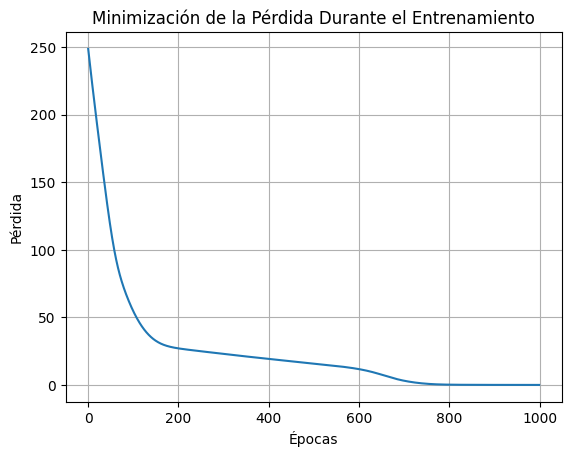

In [ ]:
# 7: Graficar la función de pérdida en función de las épocas
def graficar_perdida(historial_perdida):
    plt.plot(historial_perdida)
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Minimización de la Pérdida Durante el Entrenamiento')
    plt.grid(True)  # Agregar cuadrícula
    plt.show()

# Graficar el historial de la pérdida
graficar_perdida(historial_perdida)

In [ ]:
# 8: Visualizar la solución aproximada y la solución exacta
def graficar_solucion(modelo, T0, Tf, x_test, y_test):
    # Predicción de la red neuronal
    x_test_tf = tf.convert_to_tensor(x_test, dtype=tf.float32)
    T_predicho = modelo(x_test_tf).numpy()

    # Solución exacta usando T(x) = T0 + (Tf - T0) * x
    T_real = T0 + (Tf - T0) * x_test

    # Graficamos la solución aproximada y la solución real
    plt.plot(x_test, T_predicho, label='Solución Aproximada (PINN)', color='blue')
    plt.plot(x_test, T_real, 'r--', label='Solución Exacta', color='red')
    plt.xlabel('x')
    plt.ylabel('T(x)')
    plt.legend()
    plt.grid(True)  # Agregar cuadrícula
    plt.show()

    # Calcular y mostrar el Error Absoluto Medio (MAE)
    mae = np.mean(np.abs(T_predicho.flatten() - y_test.flatten()))  # MAE
    print(f"Error Absoluto Medio (MAE): {mae}")

    # Calcular y mostrar la precisión (MSE)
    mse = np.mean((T_predicho.flatten() - y_test.flatten())**2)
    print(f"Error Cuadrático Medio (MSE): {mse}")

    # Calcular y mostrar la precisión (en porcentaje)
    mae = np.mean(np.abs(T_predicho.flatten() - y_test.flatten()))  # Error absoluto medio (MAE)
    valor_medio_real = np.mean(y_test)  # Valor promedio de los datos de prueba reales
    precision = 100 * (1 - mae / valor_medio_real)  # Precisión en porcentaje

    print(f"Precisión: {precision:.2f}%")

<ipython-input-8-bc7635968955>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_test, T_real, 'r--', label='Solución Exacta', color='red')


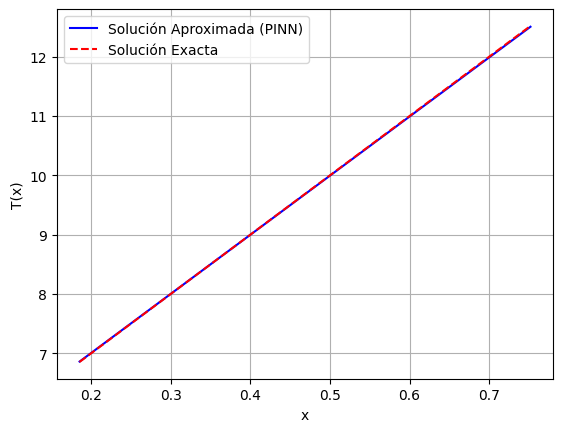

Error Absoluto Medio (MAE): 0.009899752498741865
Error Cuadrático Medio (MSE): 0.00011466519803188532
Precisión: 99.90%


In [ ]:
# Llamada a la función para graficar la solución
graficar_solucion(modelo, T0, Tf, X_test, y_test)


In [ ]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/Colab Notebooks/saved_models/PINN_v1.h5')